In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.18.1
pandas 1.0.1
scipy 1.4.1
sklearn 0.22.1
lightgbm 2.3.1


In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from tqdm import notebook
# import tqdm

from itertools import product

In [3]:
def downcast_dtypes(df):
    ''''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
                
        Downcasting dtypes will safe memory
    '''
    
    # select columns to downcast
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols =   [c for c in df if df[c].dtype == 'int64']
    
    # downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df
    
    

## Load data subset

Let's load the data frm the hard drive first

In [4]:
import zipfile

zf = zipfile.ZipFile('../final_project/competitive-data-science-predict-future-sales.zip')

In [5]:
sales = pd.read_csv(zf.open('sales_train.csv'))
shops = pd.read_csv(zf.open('shops.csv'))
items = pd.read_csv(zf.open('items.csv'))
item_cats = pd.read_csv(zf.open('item_categories.csv'))

and use only 3 shops for simplicity

In [6]:
sales = sales[sales['shop_id'].isin([26,27,28])]

In [7]:
sales.shape

(301510, 6)

## Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [8]:
# create a grid with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# for every month we create a grid from all shop/itemss combinations from that month
grid = []

for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype= 'int32'))
                
# turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns= index_cols, dtype= np.int32)

# groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index= False).agg({'item_cnt_day': 'sum'})

# rename item_cnt_day as target
gb.rename(columns= {'item_cnt_day': 'target'}, inplace= True)

# join it to the grid
all_data = pd.merge(grid, gb, how= 'left', on= index_cols).fillna(0)


# sames as above with shop-month (item is not included) aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index= False).agg({'item_cnt_day': 'sum'})
gb.rename(columns= {'item_cnt_day': 'target_shop'}, inplace= True)
all_data = pd.merge(all_data, gb, how= 'left', on= ['shop_id', 'date_block_num']).fillna(0)

# sames as above with item-month (item is not included) aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index= False).agg({'item_cnt_day': 'sum'})
gb.rename(columns= {'item_cnt_day': 'target_item'}, inplace= True)
all_data = pd.merge(all_data, gb, how= 'left', on= ['item_id', 'date_block_num']).fillna(0)

# downcast dtypes from 64 to 32 to save memory
all_data = downcast_dtypes(all_data)
del grid, gb
gc.collect();

In [9]:
all_data

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,28,7738,0,4.0,7057.0,11.0
1,28,7737,0,10.0,7057.0,16.0
2,28,7770,0,6.0,7057.0,10.0
3,28,7664,0,1.0,7057.0,1.0
4,28,7814,0,2.0,7057.0,6.0
...,...,...,...,...,...,...
278614,26,21760,33,0.0,1409.0,1.0
278615,26,21956,33,0.0,1409.0,2.0
278616,26,21976,33,0.0,1409.0,2.0
278617,26,21881,33,0.0,1409.0,2.0


In [10]:
# list of columns that we will use to create lags. 
# the outcome of this command is the name of the target columns we created
cols_to_rename = list(all_data.columns.difference(index_cols))

shift_range = [1, 2, 3, 4, 5, 12]

# for month_shift in tqdwm_notebook(shift_range)
for month_shift in notebook.tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] =  train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns= foo)
    
    all_data = pd.merge(all_data, train_shift, on= index_cols, how= 'left').fillna(0)
    
del train_shift

# dont's use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# list of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]   

# we will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()

# merge the item_category_mapping into the all data dataframe
all_data = pd.merge(all_data, item_category_mapping, how= 'left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();


In [11]:
all_data

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157945,26,21760,33,0.0,1409.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1007.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1900.0,41
157946,26,21956,33,0.0,1409.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,953.0,0.0,0.0,0.0,0.0,0.0,0.0,61
157947,26,21976,33,0.0,1409.0,2.0,1.0,1.0,1553.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,953.0,0.0,0.0,0.0,0.0,0.0,0.0,61
157948,26,21881,33,0.0,1409.0,2.0,0.0,2.0,1553.0,0.0,3.0,1189.0,0.0,4.0,1007.0,0.0,2.0,953.0,0.0,8.0,1358.0,0.0,0.0,0.0,40


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [12]:
# save 'date_block_num', as we can't use them as features, but will need them to split the dataset into parts
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [13]:
dates_train = dates[dates < last_block]
dates_test = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis= 1)
X_test  = all_data.loc[dates == last_block].drop(to_drop_cols, axis= 1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test  = all_data.loc[dates == last_block, 'target'].values

# First level models

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [14]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


And then we run *LightGBM*

In [15]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

# keep in mind that the ytrain is a 1D array
model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.736842


Finally concatenate test predictions to get test meta-features

In [16]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [17]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# that is how we gt target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [18]:
#and here we create a 2nd level feature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print('_'*40)
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis= 1)
    X_test  = all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis= 1)

    y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur  = all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test.values)
        
    print('Test R-squared for linreg is %f' % r2_score(y_test_cur, pred_lr))
    
    # keep in mind that the ytrain is a 1D array
    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)
    
    print('Test R-squared for LightGBM is %f' % r2_score(y_test_cur, pred_lgb))
    
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[pred_lr, pred_lgb]
    
# Sanity check
# assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))
# I added this line as in the original script.  Nontheless, the value changed slightly due to
# my LightGBM library version

________________________________________
27
Test R-squared for linreg is 0.485961
Test R-squared for LightGBM is 0.271576
________________________________________
28
Test R-squared for linreg is 0.549966
Test R-squared for LightGBM is 0.475652
________________________________________
29
Test R-squared for linreg is 0.796330
Test R-squared for LightGBM is 0.608881
________________________________________
30
Test R-squared for linreg is 0.799710
Test R-squared for LightGBM is 0.639048
________________________________________
31
Test R-squared for linreg is 0.843263
Test R-squared for LightGBM is 0.687528
________________________________________
32
Test R-squared for linreg is 0.398219
Test R-squared for LightGBM is 0.403944


In [19]:
X_train_level2.mean(axis=0)

array([1.50148988, 1.38406219])

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

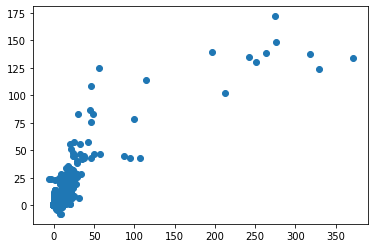

In [20]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1]);

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [21]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = 0 
r2_train_simple_mix = 0

for alpha in alphas_to_try:
    mix = alpha * X_train_level2[:, 0] + (1 - alpha) * X_train_level2[:, 1]
    r2 = r2_score(y_train_level2, mix)
    if r2 > r2_train_simple_mix:
        best_alpha = alpha
        r2_train_simple_mix = r2
        
print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.763000; Corresponding r2 score on train: 0.627463


Now use the $\alpha$ you've found to compute predictions for the test set

In [22]:
test_preds = best_alpha * X_test_level2[:, 0] + (1 - best_alpha) * X_test_level2[:, 1] # YOUR CODE GOES HERE
r2_test_simple_mix = r2_score(y_test, test_preds)# YOUR CODE GOES HERE

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781679


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [26]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
print('Coefficient:            {}'.format(lr.coef_))
print('Normalized Coefficient: {}'.format(lr.coef_ / lr.coef_.sum()))

Coefficient:            [0.80463019 0.10013661]
Normalized Coefficient: [0.88932329 0.11067671]


Compute R-squared on the train and test sets.

In [29]:
train_preds = lr.predict(X_train_level2) # YOUR CODE GOES HERE
r2_train_stacking = r2_score(y_train_level2, train_preds) # YOUR CODE GOES HERE

test_preds = lr.predict(X_test_level2) # YOUR CODE GOES HERE
r2_test_stacking = r2_score(y_test, test_preds)# YOUR CODE GOES HERE

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632206
Test  R-squared for stacking is 0.771887
